# Udemy Course Reviews – Exploratory Analysis

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
%matplotlib inline

### Locate source data

In [133]:
BASE_DIR = Path.cwd().parent
RAW_REVIEW_PATHS = sorted(BASE_DIR.glob('udemy_data_*.csv'))
META_PATH = BASE_DIR / 'general_course_data.xlsx'

print(f"Found {len(RAW_REVIEW_PATHS)} standardized CSV files.")
RAW_REVIEW_PATHS[:3]

Found 22 standardized CSV files.


[WindowsPath('c:/Users/Vassil/Desktop/EDA/udemy_data_1.csv'),
 WindowsPath('c:/Users/Vassil/Desktop/EDA/udemy_data_10.csv'),
 WindowsPath('c:/Users/Vassil/Desktop/EDA/udemy_data_11.csv')]

### Peek at a single review extract

In [134]:
sample_df = pd.read_csv(RAW_REVIEW_PATHS[0])
sample_df.head()

,source_file,course_url,course_slug,reviewer_name,review_text,rating_value,rating_scale,review_time_relative
0,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Avinash A.,"Fantastic course, covering all aspects of AI f...",5.0,5.0,1 week ago
1,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Gorun B.,"I loved it, Overall I would give it 4 because ...",4.0,5.0,2 weeks ago
2,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Pradeep Singh L.,An excellent course that provides valuable ins...,4.0,5.0,3 weeks ago
3,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Udemy User,There is so much information in this course. E...,5.0,5.0,3 weeks ago
4,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Eduardo A.,I can confidently say it was an awesome course...,5.0,5.0,1 month ago


## 1. Combine review datasets

In [135]:
review_frames = []
for path in RAW_REVIEW_PATHS:
    df = pd.read_csv(path)
    df['source_file_origin'] = path.name
    review_frames.append(df)

reviews = pd.concat(review_frames, ignore_index=True)
print(f"Combined shape: {reviews.shape}")
reviews.head()

Combined shape: (16165, 9)


,source_file,course_url,course_slug,reviewer_name,review_text,rating_value,rating_scale,review_time_relative,source_file_origin
0,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Avinash A.,"Fantastic course, covering all aspects of AI f...",5.0,5.0,1 week ago,udemy_data_1.csv
1,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Gorun B.,"I loved it, Overall I would give it 4 because ...",4.0,5.0,2 weeks ago,udemy_data_1.csv
2,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Pradeep Singh L.,An excellent course that provides valuable ins...,4.0,5.0,3 weeks ago,udemy_data_1.csv
3,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Udemy User,There is so much information in this course. E...,5.0,5.0,3 weeks ago,udemy_data_1.csv
4,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Eduardo A.,I can confidently say it was an awesome course...,5.0,5.0,1 month ago,udemy_data_1.csv


### Basic structure checks

In [136]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16165 entries, 0 to 16164
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   source_file           16165 non-null  object 
 1   course_url            16165 non-null  object 
 2   course_slug           16165 non-null  object 
 3   reviewer_name         16165 non-null  object 
 4   review_text           16115 non-null  object 
 5   rating_value          16165 non-null  float64
 6   rating_scale          16165 non-null  float64
 7   review_time_relative  16143 non-null  object 
 8   source_file_origin    16165 non-null  object 
dtypes: float64(2), object(7)
memory usage: 1.1+ MB


In [137]:
reviews.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
rating_value,16165.0,4.573647,0.838627,1.0,4.5,5.0,5.0,5.0
rating_scale,16165.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0


In [138]:
(reviews['rating_value'].value_counts(dropna=False)
        .rename_axis('rating_value')
        .reset_index(name='count')
        .head(10))

,rating_value,count
0,5.0,10863
1,4.5,2005
2,4.0,1520
3,3.0,505
4,3.5,503
5,1.0,365
6,2.5,186
7,2.0,166
8,1.5,52


In [139]:
(reviews.groupby('course_slug').size()
        .sort_values(ascending=False)
        .head(22))

course_slug
complete-ai-guide                                                      4524
llm-engineering-master-ai-and-large-language-models                    2335
the-complete-agentic-ai-engineering-course                             1944
complete-machine-learning-nlp-bootcamp-mlops-deployment                1812
the-product-management-for-data-science-ai-course                      1251
ai-automation-build-llm-apps-ai-agents-with-n8n-apis                    814
ai-agents-automation-business-with-langchain-llm-apps                   519
ai-agents-building-teams-of-llm-agents-that-work-for-you                357
aws-certified-machine-learning-engineer-associate-mla-c01               321
n8n-course                                                              312
data-science-ai-masters-from-python-to-gen-ai                           296
complete-mlops-bootcamp-with-10-end-to-end-ml-projects                  284
aws-machine-learning-practice-exam                                      250


## 2. Helper dictionaries and parsing utilities

In [140]:
STOPWORDS = {
    'the', 'and', 'for', 'with', 'that', 'this', 'from', 'have', 'was', 'but',
    'are', 'not', 'you', 'your', 'all', 'about', 'which', 'will', 'they',
    'their', 'been', 'there', 'more', 'when', 'what', 'into', 'than', 'them',
    'out', 'can', 'get', 'she', 'his', 'her', 'our', 'has', 'had', 'were',
    'who', 'where', 'why', 'how', 'also', 'any', 'much', 'many', 'very', 'just',
    'too', 'did', 'does', 'done', 'dont', 'didnt', 'cant', 'could', 'should',
    'would', 'then', 'because', 'being', 'some', 'most', 'even', 'ever',
    'each', 'every', 'those', 'these', 'through', 'while', 'same', 'make', 'made',
    'still', 'over', 'under', 'again', 'back', 'down', 'only', 'really', 'able',
    'want', 'needs', 'need', 'using', 'used', 'use', 'takes', 'take', 'took',
    'thing', 'things', 'course', 'udemy', 'section', 'sections', 'lesson',
    'lessons', 'video', 'videos', 'content', 'material', 'materials', 'topic',
    'topics', 'module', 'modules'
}

POSITIVE_WORDS = {
    'great', 'excellent', 'amazing', 'good', 'helpful', 'clear', 'comprehensive',
    'useful', 'fantastic', 'easy', 'practical', 'engaging', 'outstanding',
    'insightful', 'best', 'awesome', 'valuable', 'love', 'recommend', 'perfect',
    'brilliant', 'solid', 'interesting', 'enjoyed', 'enjoy', 'well', 'structured',
    'detailed', 'informative', 'supportive', 'effective', 'friendly', 'professional',
    'thorough', 'superb', 'satisfied', 'exceptional', 'enthusiastic', 'pleased'
}

NEGATIVE_WORDS = {
    'bad', 'poor', 'confusing', 'boring', 'slow', 'difficult', 'hard', 'waste',
    'terrible', 'awful', 'worst', 'disappointed', 'disappointing', 'problem',
    'issues', 'issue', 'bug', 'bugs', 'error', 'errors', 'incomplete',
    'repetitive', 'redundant', 'lack', 'lacking', 'missing', 'outdated',
    'useless', 'hate', 'annoying', 'annoyed', 'frustrating', 'frustrated',
    'messy', 'confused', 'complex', 'complicated', 'unstructured', 'unclear',
    'short', 'expensive', 'costly', 'rushed', 'stuck', 'lag', 'laggy', 'sloppy'
}

TOKEN_PATTERN = re.compile(r"[A-Za-z']+")


def tokenize(text: str) -> list:
    tokens = []
    if pd.isna(text):
        return tokens
    for match in TOKEN_PATTERN.findall(str(text).lower()):
        token = match.strip("'")
        if len(token) < 3 or token in STOPWORDS:
            continue
        tokens.append(token)
    return tokens


def parse_relative_time(value) -> float:
    if pd.isna(value):
        return np.nan
    text = str(value).strip().lower()
    if not text:
        return np.nan
    for prefix in ('about ', 'over ', 'almost ', 'nearly '):
        if text.startswith(prefix):
            text = text[len(prefix):]
    if text in {'today', 'just now'}:
        return 0.0
    if text == 'yesterday':
        return 1.0 / 7.0
    text = text.replace('ago', '').strip()
    if text.startswith('an '):
        text = text.replace('an ', '1 ', 1)
    if text.startswith('a '):
        text = text.replace('a ', '1 ', 1)
    match = re.match(r'(\d+(?:\.\d+)?)\s+([a-z]+)', text)
    if not match:
        return np.nan
    value_num = float(match.group(1))
    unit = match.group(2)
    multipliers = {
        'minute': 1.0 / (60 * 24 * 7),
        'minutes': 1.0 / (60 * 24 * 7),
        'hour': 1.0 / (24 * 7),
        'hours': 1.0 / (24 * 7),
        'day': 1.0 / 7.0,
        'days': 1.0 / 7.0,
        'week': 1.0,
        'weeks': 1.0,
        'month': 4.345,
        'months': 4.345,
        'year': 52.0,
        'years': 52.0,
    }
    return value_num * multipliers.get(unit, np.nan)


def parse_currency(value) -> float:
    if pd.isna(value):
        return np.nan
    text = str(value).strip()
    if not text:
        return np.nan
    if 'miễn' in text.lower():
        return 0.0
    digits = re.sub(r'[^0-9]', '', text)
    if not digits:
        return np.nan
    return float(digits)


def parse_content_length(value) -> float:
    if pd.isna(value):
        return np.nan
    text = str(value).lower()
    match = re.search(r'(\d+(?:\.\d+)?)', text)
    if not match:
        return np.nan
    quantity = float(match.group(1))
    if 'min' in text:
        return quantity / 60.0
    return quantity


def top_ngrams(tokens_series: pd.Series, n: int, top_n: int = 15) -> list:
    counter = Counter()
    for tokens in tokens_series:
        if not tokens or len(tokens) < n:
            continue
        for idx in range(len(tokens) - n + 1):
            ngram = tuple(tokens[idx: idx + n])
            counter[ngram] += 1
    formatted = []
    for ngram, count in counter.most_common(top_n):
        term = ' '.join(ngram)
        formatted.append((term, int(count)))
    return formatted


## 3. Feature engineering on reviews

In [141]:
for column in ('rating_value', 'rating_scale'):
    reviews[column] = pd.to_numeric(reviews[column], errors='coerce')

reviews['review_text'] = reviews['review_text'].fillna('').astype(str)
reviews['reviewer_name'] = reviews['reviewer_name'].fillna('Unknown Reviewer')
reviews['review_word_count'] = reviews['review_text'].str.split().apply(len)
reviews['review_char_count'] = reviews['review_text'].str.len()

reviews.head()

,source_file,course_url,course_slug,reviewer_name,review_text,rating_value,rating_scale,review_time_relative,source_file_origin,review_word_count,review_char_count
0,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Avinash A.,"Fantastic course, covering all aspects of AI f...",5.0,5.0,1 week ago,udemy_data_1.csv,28,164
1,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Gorun B.,"I loved it, Overall I would give it 4 because ...",4.0,5.0,2 weeks ago,udemy_data_1.csv,35,197
2,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Pradeep Singh L.,An excellent course that provides valuable ins...,4.0,5.0,3 weeks ago,udemy_data_1.csv,13,88
3,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Udemy User,There is so much information in this course. E...,5.0,5.0,3 weeks ago,udemy_data_1.csv,44,230
4,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Eduardo A.,I can confidently say it was an awesome course...,5.0,5.0,1 month ago,udemy_data_1.csv,38,201


In [142]:
rating_mean = reviews['rating_value'].mean()
reviews['rating_missing'] = reviews['rating_value'].isna()
reviews['rating_value_filled'] = reviews['rating_value']
course_means = reviews.groupby('course_slug')['rating_value'].transform('mean')
reviews.loc[reviews['rating_value_filled'].isna(), 'rating_value_filled'] = course_means
reviews['rating_value_filled'] = reviews['rating_value_filled'].fillna(rating_mean)

scale_mode = reviews['rating_scale'].mode().iloc[0] if not reviews['rating_scale'].mode().empty else 5.0
reviews['rating_scale_filled'] = reviews['rating_scale'].fillna(scale_mode)
reviews['normalized_rating'] = reviews['rating_value_filled'] / reviews['rating_scale_filled'].replace(0, np.nan)

reviews[['rating_value', 'rating_value_filled', 'rating_scale', 'rating_scale_filled', 'normalized_rating']].head()

,rating_value,rating_value_filled,rating_scale,rating_scale_filled,normalized_rating
0,5.0,5.0,5.0,5.0,1.0
1,4.0,4.0,5.0,5.0,0.8
2,4.0,4.0,5.0,5.0,0.8
3,5.0,5.0,5.0,5.0,1.0
4,5.0,5.0,5.0,5.0,1.0


In [143]:
reviews['weeks_ago'] = reviews['review_time_relative'].apply(parse_relative_time)
reviews['recent_flag'] = np.where(reviews['weeks_ago'].notna(), (reviews['weeks_ago'] <= 4).astype(float), np.nan)
reviews[['review_time_relative', 'weeks_ago', 'recent_flag']].head()

,review_time_relative,weeks_ago,recent_flag
0,1 week ago,1.000,1.0
1,2 weeks ago,2.000,1.0
2,3 weeks ago,3.000,1.0
3,3 weeks ago,3.000,1.0
4,1 month ago,4.345,0.0


In [144]:
reviews['tokens'] = reviews['review_text'].apply(tokenize)
reviews['positive_word_count'] = reviews['tokens'].apply(lambda tokens: sum(token in POSITIVE_WORDS for token in tokens))
reviews['negative_word_count'] = reviews['tokens'].apply(lambda tokens: sum(token in NEGATIVE_WORDS for token in tokens))
reviews['sentiment_score'] = reviews['positive_word_count'] - reviews['negative_word_count']
reviews['sentiment_label'] = np.select([
    reviews['sentiment_score'] > 0,
    reviews['sentiment_score'] < 0
], ['positive', 'negative'], default='neutral')
reviews['sentiment_label'].value_counts()

sentiment_label
positive    10910
neutral      4854
negative      401
Name: count, dtype: int64

In [145]:
(reviews.isna().mean()
        .sort_values(ascending=False)
        .head(10)
        .mul(100)
        .rename('missing_pct'))

weeks_ago               0.136097
review_time_relative    0.136097
recent_flag             0.136097
course_slug             0.000000
source_file             0.000000
course_url              0.000000
rating_value            0.000000
review_text             0.000000
reviewer_name           0.000000
rating_scale            0.000000
Name: missing_pct, dtype: float64

## 4. Enrich with course metadata

In [146]:
meta = pd.read_excel(META_PATH)
meta.head()

,course_url,course_slug,course_title,course_badge,skill_level,lecture_count,content_length,original_price(VNĐ),discount_price(VNĐ),num_students
0,https://www.udemy.com/course/data-science-ai-m...,data-science-ai-masters-from-python-to-gen-ai,Data Science & AI Masters 2025 - From Python T...,Bestseller,All levels,519.0,98h 14m,1239000,309000,17581
1,https://www.udemy.com/course/the-complete-ai-c...,the-complete-ai-coding-course-2025-cursor-ai-v...,"The Complete AI Coding Course (2025) - Cursor,...",Bestseller,All levels,128.0,11h 48m,409000,309000,7906
2,https://www.udemy.com/course/complete-machine-...,complete-machine-learning-nlp-bootcamp-mlops-d...,"Complete Data Science,Machine Learning,DL,NLP ...",Bestseller,All levels,429.0,99h 10m,1499000,339000,107007
3,https://www.udemy.com/course/generative-ai-for...,generative-ai-for-data-engineering,Introduction to Data Engineering using Generat...,NaN,All levels,56.0,6h 7m,799000,279000,3805
4,https://www.udemy.com/course/the-product-manag...,the-product-management-for-data-science-ai-course,The Product Management for AI & Data Science C...,Bestseller,All levels,68.0,4h 54m,2269000,479000,38826


In [147]:
meta = meta.rename(columns={
    'original_price(VNĐ)': 'original_price_raw',
    'discount_price(VNĐ)': 'discount_price_raw'
})
meta['lecture_count'] = pd.to_numeric(meta['lecture_count'], errors='coerce')
meta['content_hours'] = meta['content_length'].apply(parse_content_length)
meta['original_price_vnd'] = meta['original_price_raw'].apply(parse_currency)
meta['discount_price_vnd'] = meta['discount_price_raw'].apply(parse_currency)
meta['discount_pct'] = np.where(
    meta['original_price_vnd'].notna() & (meta['original_price_vnd'] > 0),
    1 - (meta['discount_price_vnd'] / meta['original_price_vnd']),
    np.nan,
)
meta['discount_pct'] = meta['discount_pct'].clip(lower=0)
meta.head()


,course_url,course_slug,course_title,course_badge,skill_level,lecture_count,content_length,original_price_raw,discount_price_raw,num_students,content_hours,original_price_vnd,discount_price_vnd,discount_pct
0,https://www.udemy.com/course/data-science-ai-m...,data-science-ai-masters-from-python-to-gen-ai,Data Science & AI Masters 2025 - From Python T...,Bestseller,All levels,519.0,98h 14m,1239000,309000,17581,98.0,1239000.0,309000.0,0.750605
1,https://www.udemy.com/course/the-complete-ai-c...,the-complete-ai-coding-course-2025-cursor-ai-v...,"The Complete AI Coding Course (2025) - Cursor,...",Bestseller,All levels,128.0,11h 48m,409000,309000,7906,11.0,409000.0,309000.0,0.244499
2,https://www.udemy.com/course/complete-machine-...,complete-machine-learning-nlp-bootcamp-mlops-d...,"Complete Data Science,Machine Learning,DL,NLP ...",Bestseller,All levels,429.0,99h 10m,1499000,339000,107007,99.0,1499000.0,339000.0,0.773849
3,https://www.udemy.com/course/generative-ai-for...,generative-ai-for-data-engineering,Introduction to Data Engineering using Generat...,NaN,All levels,56.0,6h 7m,799000,279000,3805,6.0,799000.0,279000.0,0.650814
4,https://www.udemy.com/course/the-product-manag...,the-product-management-for-data-science-ai-course,The Product Management for AI & Data Science C...,Bestseller,All levels,68.0,4h 54m,2269000,479000,38826,4.0,2269000.0,479000.0,0.788894


In [148]:
combined = reviews.merge(meta, on='course_slug', how='left', suffixes=('', '_course'))
combined['course_badge'] = combined['course_badge'].fillna('No badge')
combined['skill_level'] = combined['skill_level'].fillna('Unspecified')
combined['num_students'] = pd.to_numeric(combined['num_students'], errors='coerce')

combined['price_per_hour'] = np.where(
    combined['content_hours'].notna() & (combined['content_hours'] > 0),
    combined['discount_price_vnd'] / combined['content_hours'],
    np.nan,
)
combined['students_per_hour'] = np.where(
    combined['content_hours'].notna() & (combined['content_hours'] > 0),
    combined['num_students'] / combined['content_hours'],
    np.nan,
)
combined['students_per_lecture'] = np.where(
    combined['lecture_count'].notna() & (combined['lecture_count'] > 0),
    combined['num_students'] / combined['lecture_count'],
    np.nan,
)
combined['rating_per_hour'] = np.where(
    combined['content_hours'].notna() & (combined['content_hours'] > 0),
    combined['rating_value_filled'] / combined['content_hours'],
    np.nan,
)
combined['log_num_students'] = np.log1p(combined['num_students'])
combined['log_discount_price'] = np.log1p(combined['discount_price_vnd'])
combined['log_price_per_hour'] = np.log1p(combined['price_per_hour'])

combined.head()


,source_file,course_url,course_slug,reviewer_name,review_text,rating_value,rating_scale,review_time_relative,source_file_origin,review_word_count,review_char_count,rating_missing,rating_value_filled,rating_scale_filled,normalized_rating,weeks_ago,recent_flag,tokens,positive_word_count,negative_word_count,sentiment_score,sentiment_label,course_url_course,course_title,course_badge,skill_level,lecture_count,content_length,original_price_raw,discount_price_raw,num_students,content_hours,original_price_vnd,discount_price_vnd,discount_pct,price_per_hour,students_per_hour,students_per_lecture,rating_per_hour,log_num_students,log_discount_price,log_price_per_hour
0,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Avinash A.,"Fantastic course, covering all aspects of AI f...",5.0,5.0,1 week ago,udemy_data_1.csv,28,164,False,5.0,5.0,1.0,1.000,1.0,"[fantastic, covering, aspects, basic, expert, ...",2,0,2,positive,https://www.udemy.com/course/complete-ai-guide...,"The Complete AI Guide: Learn ChatGPT, Generati...",Bestseller,All levels,521.0,39h 38m,1909000,349000,306022,39.0,1909000.0,349000.0,0.817182,8948.717949,7846.717949,587.37428,0.128205,12.631416,12.76283,9.099377
1,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Gorun B.,"I loved it, Overall I would give it 4 because ...",4.0,5.0,2 weeks ago,udemy_data_1.csv,35,197,False,4.0,5.0,0.8,2.000,1.0,"[loved, overall, give, stuff, overly, kept, re...",0,0,0,neutral,https://www.udemy.com/course/complete-ai-guide...,"The Complete AI Guide: Learn ChatGPT, Generati...",Bestseller,All levels,521.0,39h 38m,1909000,349000,306022,39.0,1909000.0,349000.0,0.817182,8948.717949,7846.717949,587.37428,0.102564,12.631416,12.76283,9.099377
2,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Pradeep Singh L.,An excellent course that provides valuable ins...,4.0,5.0,3 weeks ago,udemy_data_1.csv,13,88,False,4.0,5.0,0.8,3.000,1.0,"[excellent, provides, valuable, insights, tool...",2,0,2,positive,https://www.udemy.com/course/complete-ai-guide...,"The Complete AI Guide: Learn ChatGPT, Generati...",Bestseller,All levels,521.0,39h 38m,1909000,349000,306022,39.0,1909000.0,349000.0,0.817182,8948.717949,7846.717949,587.37428,0.102564,12.631416,12.76283,9.099377
3,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Udemy User,There is so much information in this course. E...,5.0,5.0,3 weeks ago,udemy_data_1.csv,44,230,False,5.0,5.0,1.0,3.000,1.0,"[information, though, lengthy, felt, i'm, brou...",0,0,0,neutral,https://www.udemy.com/course/complete-ai-guide...,"The Complete AI Guide: Learn ChatGPT, Generati...",Bestseller,All levels,521.0,39h 38m,1909000,349000,306022,39.0,1909000.0,349000.0,0.817182,8948.717949,7846.717949,587.37428,0.128205,12.631416,12.76283,9.099377
4,udemy_data (1).xlsx,https://www.udemy.com/course/complete-ai-guide...,complete-ai-guide,Eduardo A.,I can confidently say it was an awesome course...,5.0,5.0,1 month ago,udemy_data_1.csv,38,201,False,5.0,5.0,1.0,4.345,0.0,"[confidently, say, awesome, introduced, wide, ...",1,0,1,positive,https://www.udemy.com/course/complete-ai-guide...,"The Complete AI Guide: Learn ChatGPT, Generati...",Bestseller,All levels,521.0,39h 38m,1909000,349000,306022,39.0,1909000.0,349000.0,0.817182,8948.717949,7846.717949,587.37428,0.128205,12.631416,12.76283,9.099377


### Quick data quality checks

In [149]:
duplicate_mask = combined.duplicated(subset=['course_slug', 'reviewer_name', 'review_text'], keep=False)
print(f"Potential duplicate reviews: {duplicate_mask.sum()}")
invalid_rating_mask = (combined['rating_value_filled'] < 0) | (combined['rating_value_filled'] > combined['rating_scale_filled'])
print(f"Ratings outside expected scale: {invalid_rating_mask.sum()}")


Potential duplicate reviews: 194
Ratings outside expected scale: 0


## 5. Aggregations for course-level insights

In [150]:
reviews_per_course = (combined.groupby(['course_slug', 'course_title'], dropna=False)
    .agg(
        review_count=('normalized_rating', 'size'),
        avg_rating=('rating_value_filled', 'mean'),
        avg_norm_rating=('normalized_rating', 'mean'),
        avg_sentiment=('sentiment_score', 'mean'),
        median_weeks_ago=('weeks_ago', 'median')
    )
    .reset_index()
)
reviews_per_course.sort_values('review_count', ascending=False).head()


,course_slug,course_title,review_count,avg_rating,avg_norm_rating,avg_sentiment,median_weeks_ago
7,complete-ai-guide,"The Complete AI Guide: Learn ChatGPT, Generati...",4524,4.499779,0.899956,0.872679,52.000
16,llm-engineering-master-ai-and-large-language-m...,"LLM Engineering: Master AI, Large Language Mod...",2335,4.743683,0.948737,1.233833,21.725
19,the-complete-agentic-ai-engineering-course,The Complete Agentic AI Engineering Course (2025),1944,4.784722,0.956944,1.170782,8.690
8,complete-machine-learning-nlp-bootcamp-mlops-d...,"Complete Data Science,Machine Learning,DL,NLP ...",1812,4.525386,0.905077,0.833885,34.760
21,the-product-management-for-data-science-ai-course,The Product Management for AI & Data Science C...,1251,4.366507,0.873301,0.907274,104.000


In [151]:
def compute_trend_score(group: pd.DataFrame) -> float:
    subset = group.dropna(subset=['weeks_ago'])
    if subset.empty:
        return 0.0
    series = subset.groupby('weeks_ago').size().reset_index(name='count')
    if len(series) < 2:
        return 0.0
    x = -series['weeks_ago'].to_numpy(dtype=float)
    y = series['count'].to_numpy(dtype=float)
    if np.allclose(y, y[0]):
        return 0.0
    slope, _ = np.polyfit(x, y, 1)
    return float(slope)


In [152]:
course_trend = pd.DataFrame([
    {'course_slug': slug, 'trend_score': compute_trend_score(group)}
    for slug, group in combined.groupby('course_slug')
])
recent_share = (combined.groupby('course_slug')['recent_flag']
                .mean()
                .rename('recent_share')
                .reset_index())

course_features = (combined.groupby('course_slug')
    .agg(
        course_badge=('course_badge', 'first'),
        skill_level=('skill_level', 'first'),
        discount_price_vnd=('discount_price_vnd', 'mean'),
        original_price_vnd=('original_price_vnd', 'mean'),
        discount_pct=('discount_pct', 'mean'),
        num_students=('num_students', 'mean'),
        content_hours=('content_hours', 'mean'),
        lecture_count=('lecture_count', 'mean'),
        price_per_hour=('price_per_hour', 'mean'),
        students_per_hour=('students_per_hour', 'mean'),
        students_per_lecture=('students_per_lecture', 'mean')
    )
    .reset_index()
)

course_summary = (reviews_per_course
    .merge(course_trend, on='course_slug', how='left')
    .merge(recent_share, on='course_slug', how='left')
    .merge(course_features, on='course_slug', how='left')
)

course_summary['reviews_per_student'] = np.where(
    course_summary['num_students'] > 0,
    course_summary['review_count'] / course_summary['num_students'],
    np.nan
)
course_summary['discount_price_per_student'] = np.where(
    course_summary['num_students'] > 0,
    course_summary['discount_price_vnd'] / course_summary['num_students'],
    np.nan
)
course_summary['recent_reviews_est'] = course_summary['review_count'] * course_summary['recent_share']
course_summary['trend_per_review'] = course_summary['trend_score'] / (course_summary['review_count'] + 1e-6)
course_summary['rating_vs_catalog'] = course_summary['avg_rating'] - rating_mean
course_summary['reviews_per_hour'] = np.where(
    course_summary['content_hours'] > 0,
    course_summary['review_count'] / course_summary['content_hours'],
    np.nan
)
course_summary['recent_reviews_density'] = np.where(
    course_summary['content_hours'] > 0,
    course_summary['recent_reviews_est'] / course_summary['content_hours'],
    np.nan
)
course_summary['rating_to_price_ratio'] = np.where(
    course_summary['discount_price_vnd'] > 0,
    course_summary['avg_rating'] / course_summary['discount_price_vnd'],
    np.nan
)

course_summary.head()


,course_slug,course_title,review_count,avg_rating,avg_norm_rating,avg_sentiment,median_weeks_ago,trend_score,recent_share,course_badge,skill_level,discount_price_vnd,original_price_vnd,discount_pct,num_students,content_hours,lecture_count,price_per_hour,students_per_hour,students_per_lecture,reviews_per_student,discount_price_per_student,recent_reviews_est,trend_per_review,rating_vs_catalog,reviews_per_hour,recent_reviews_density,rating_to_price_ratio
0,agentic-ai-for-automation-multi-agent-autogen,Learn Agentic AI – Build Multi-Agent Automatio...,69,4.623188,0.924638,1.000000,4.345,-1.720149,0.362319,Bestseller,All levels,309000.0,1119000.0,0.723861,8065.0,9.0,65.0,34333.333333,896.111111,124.076923,0.008555,38.313701,25.0,-0.024930,0.049542,7.666667,2.777778,0.000015
1,ai-agents-automation-business-with-langchain-l...,AI-Agents: Automation & Business with LangChai...,519,4.559730,0.911946,0.924855,30.415,-0.462816,0.019268,Bestseller,All levels,289000.0,399000.0,0.275689,24309.0,10.0,80.0,28900.000000,2430.900000,303.862500,0.021350,11.888601,10.0,-0.000892,-0.013917,51.900000,1.000000,0.000016
2,ai-agents-building-teams-of-llm-agents-that-wo...,AI Agents: Building Teams of LLM Agents that W...,357,4.488796,0.897759,0.775910,4.345,0.222685,0.294118,No badge,All levels,299000.0,1189000.0,0.748528,14641.0,9.0,49.0,33222.222222,1626.777778,298.795918,0.024384,20.422102,105.0,0.000624,-0.084851,39.666667,11.666667,0.000015
3,ai-agents-workflows-the-practical-guide,AI Agents & Workflows - The Practical Guide,171,4.640351,0.928070,1.029240,8.690,-9.696939,0.216374,Bestseller,All levels,299000.0,1099000.0,0.727934,10091.0,4.0,58.0,74750.000000,2522.750000,173.982759,0.016946,29.630364,37.0,-0.056707,0.066704,42.750000,9.250000,0.000016
4,ai-automation-build-llm-apps-ai-agents-with-n8...,AI Automation: Build LLM Apps & AI-Agents with...,814,4.722973,0.944595,0.937346,13.035,-5.321618,0.090909,Bestseller,All levels,319000.0,429000.0,0.256410,38324.0,14.0,91.0,22785.714286,2737.428571,421.142857,0.021240,8.323766,74.0,-0.006538,0.149326,58.142857,5.285714,0.000015


In [153]:
top_courses = (course_summary[course_summary['review_count'] >= 10]
    .sort_values(['avg_rating', 'review_count'], ascending=[False, False])
    .head(10)
    .reset_index(drop=True)
)

top_courses[['course_title', 'avg_rating', 'review_count', 'reviews_per_student', 'trend_score', 'recent_reviews_est', 'rating_vs_catalog']]


,course_title,avg_rating,review_count,reviews_per_student,trend_score,recent_reviews_est,rating_vs_catalog
0,Generative AI 2025 Executive Briefing: LLMs fo...,4.844186,215,0.042215,-2.202418,45.000000,0.270539
1,The Complete Agentic AI Engineering Course (2025),4.784722,1944,0.016057,-9.822842,389.000000,0.211075
2,"LLM Engineering: Master AI, Large Language Mod...",4.743683,2335,0.016320,-1.072554,200.000000,0.170036
3,Data Science & AI Masters 2025 - From Python T...,4.729730,296,0.016836,-0.984935,52.000000,0.156083
4,AI Automation: Build LLM Apps & AI-Agents with...,4.722973,814,0.021240,-5.321618,74.000000,0.149326
5,[NEW] Google Cloud Generative AI Leader - 6 Fu...,4.696721,122,0.015736,-0.440630,38.581197,0.123075
6,AI Agents & Workflows - The Practical Guide,4.640351,171,0.016946,-9.696939,37.000000,0.066704
7,Learn Agentic AI – Build Multi-Agent Automatio...,4.623188,69,0.008555,-1.720149,25.000000,0.049542
8,Introduction to Data Engineering using Generat...,4.622449,98,0.025756,-0.031864,5.000000,0.048802
9,LangGraph- Develop LLM powered AI agents with ...,4.600000,245,0.012421,-0.465224,9.000000,0.026353


In [154]:
bottom_courses = (course_summary[course_summary['review_count'] >= 10]
    .sort_values(['avg_rating', 'review_count'], ascending=[True, True])
    .head(10)
    .reset_index(drop=True)
)

bottom_courses[['course_title', 'avg_rating', 'review_count', 'reviews_per_student', 'trend_score', 'recent_reviews_est', 'rating_vs_catalog']]


,course_title,avg_rating,review_count,reviews_per_student,trend_score,recent_reviews_est,rating_vs_catalog
0,"The Complete AI Coding Course (2025) - Cursor,...",3.968750,112,0.014166,-0.272077,19.0,-0.604897
1,AWS Certified Machine Learning Specialty Full ...,4.034000,250,0.014039,-0.146266,1.0,-0.539647
2,AWS Certified Machine Learning Engineer Associ...,4.311526,321,0.009120,-0.391987,26.0,-0.262120
3,The Product Management for AI & Data Science C...,4.366507,1251,0.032221,-0.582032,22.0,-0.207140
4,Complete MLOps Bootcamp With 10+ End To End ML...,4.389085,284,0.010191,-0.580909,13.0,-0.184562
5,AI Agents: Building Teams of LLM Agents that W...,4.488796,357,0.024384,0.222685,105.0,-0.084851
6,"The Complete AI Guide: Learn ChatGPT, Generati...",4.499779,4524,0.014783,-9.355610,129.0,-0.073868
7,"Complete Data Science,Machine Learning,DL,NLP ...",4.525386,1812,0.016933,-2.775156,86.0,-0.048260
8,Generative AI for Data Engineering and Data Pr...,4.532051,78,0.014764,0.169016,0.0,-0.041595
9,"n8n - AI Agents, AI Automations & AI Voice Age...",4.533654,312,0.020775,-1.951257,53.0,-0.039993


### Weekly trend snapshot

In [155]:
weekly_trend = (combined.dropna(subset=['weeks_ago'])
    .groupby('weeks_ago')
    .agg(
        review_count=('normalized_rating', 'size'),
        avg_rating=('rating_value_filled', 'mean'),
        avg_sentiment=('sentiment_score', 'mean')
    )
    .reset_index()
    .sort_values('weeks_ago')
)
weekly_trend['review_count_roll4'] = weekly_trend['review_count'].rolling(window=4, min_periods=1).mean()
weekly_trend['avg_rating_roll4'] = weekly_trend['avg_rating'].rolling(window=4, min_periods=1).mean()
weekly_trend['avg_sentiment_roll4'] = weekly_trend['avg_sentiment'].rolling(window=4, min_periods=1).mean()
weekly_trend.head()


,weeks_ago,review_count,avg_rating,avg_sentiment,review_count_roll4,avg_rating_roll4,avg_sentiment_roll4
0,0.053571,1,4.500000,0.000000,1.00,4.500000,0.000000
1,0.142857,22,4.522727,0.863636,11.50,4.511364,0.431818
2,0.285714,34,4.647059,0.882353,19.00,4.556595,0.581996
3,0.428571,44,4.704545,0.931818,25.25,4.593583,0.669452
4,0.571429,43,4.813953,0.953488,35.75,4.672071,0.907824


## 6. Visual exploration

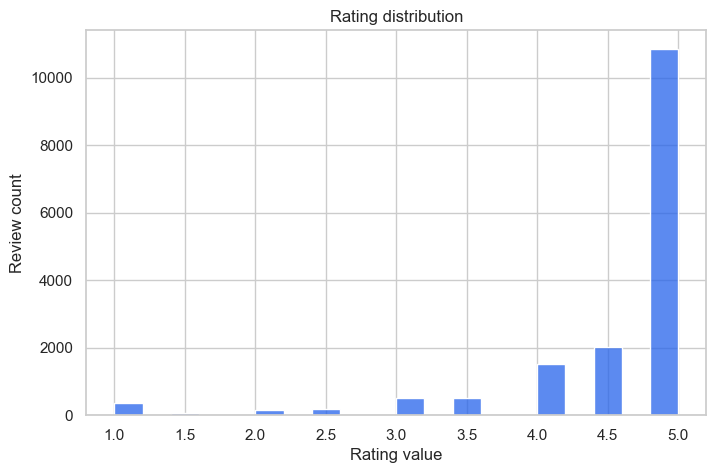

In [156]:
plt.figure(figsize=(8, 5))
sns.histplot(combined, x='rating_value_filled', bins=20, color='#2563eb')
plt.title('Rating distribution')
plt.xlabel('Rating value')
plt.ylabel('Review count')
plt.show()


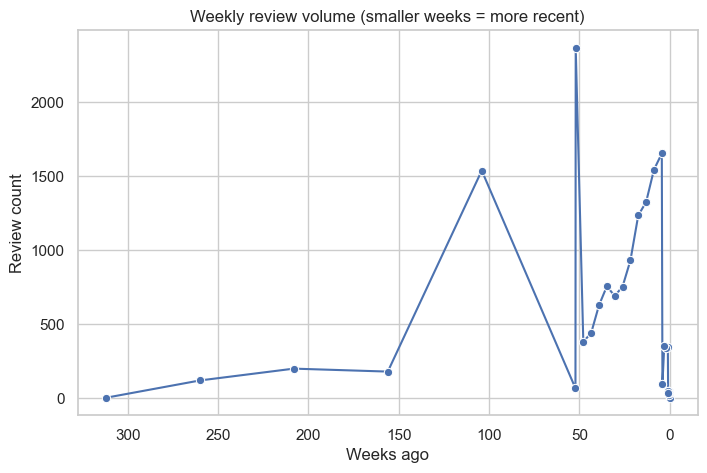

In [157]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=weekly_trend, x='weeks_ago', y='review_count', marker='o')
plt.gca().invert_xaxis()
plt.title('Weekly review volume (smaller weeks = more recent)')
plt.xlabel('Weeks ago')
plt.ylabel('Review count')
plt.show()


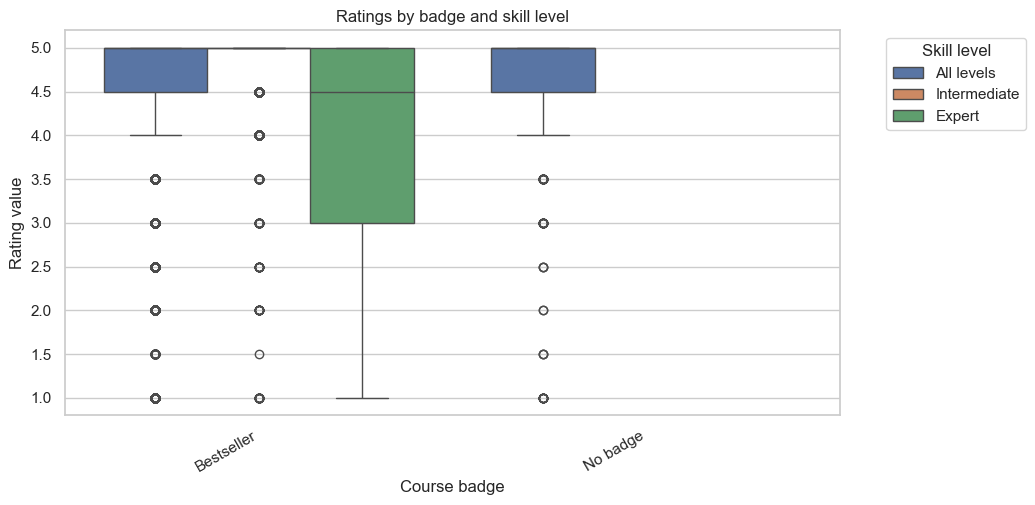

In [158]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined, x='course_badge', y='rating_value_filled', hue='skill_level')
plt.xticks(rotation=30, ha='right')
plt.title('Ratings by badge and skill level')
plt.xlabel('Course badge')
plt.ylabel('Rating value')
plt.legend(title='Skill level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


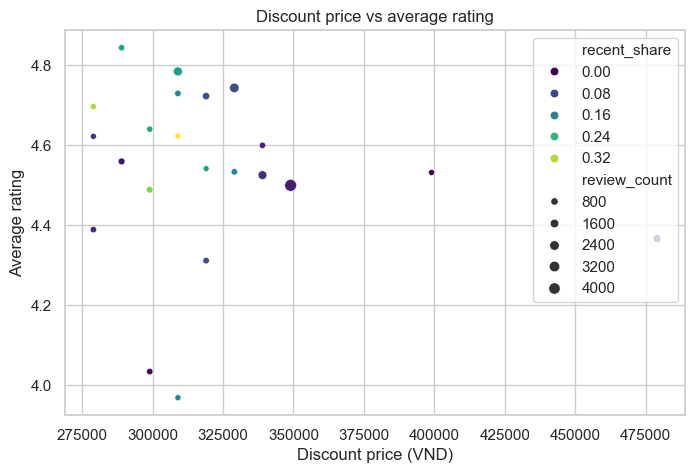

In [159]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=course_summary, x='discount_price_vnd', y='avg_rating', size='review_count', hue='recent_share', palette='viridis')
plt.title('Discount price vs average rating')
plt.xlabel('Discount price (VND)')
plt.ylabel('Average rating')
plt.show()


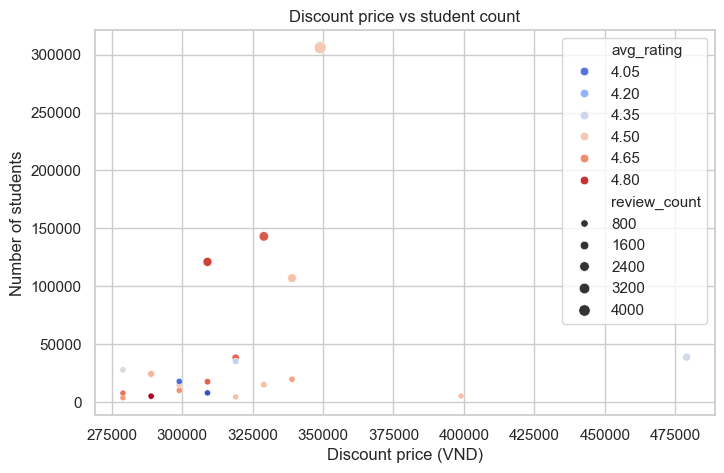

In [160]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=course_summary, x='discount_price_vnd', y='num_students', size='review_count', hue='avg_rating', palette='coolwarm')
plt.title('Discount price vs student count')
plt.xlabel('Discount price (VND)')
plt.ylabel('Number of students')
plt.show()


### Additional visualizations

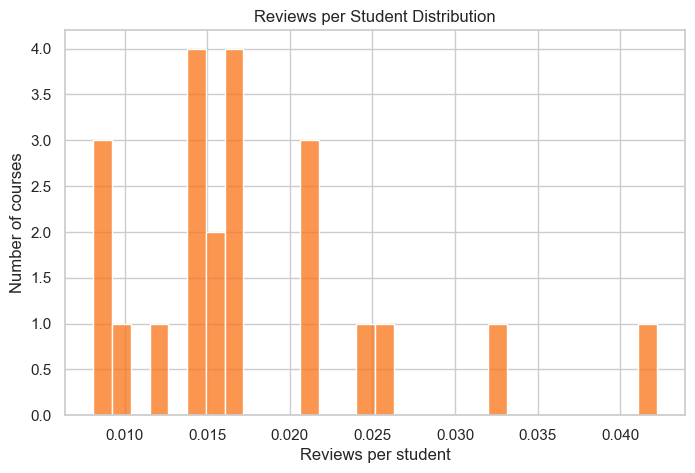

In [161]:
plt.figure(figsize=(8, 5))
sns.histplot(course_summary['reviews_per_student'].dropna(), bins=30, color='#f97316')
plt.title('Reviews per Student Distribution')
plt.xlabel('Reviews per student')
plt.ylabel('Number of courses')
plt.show()


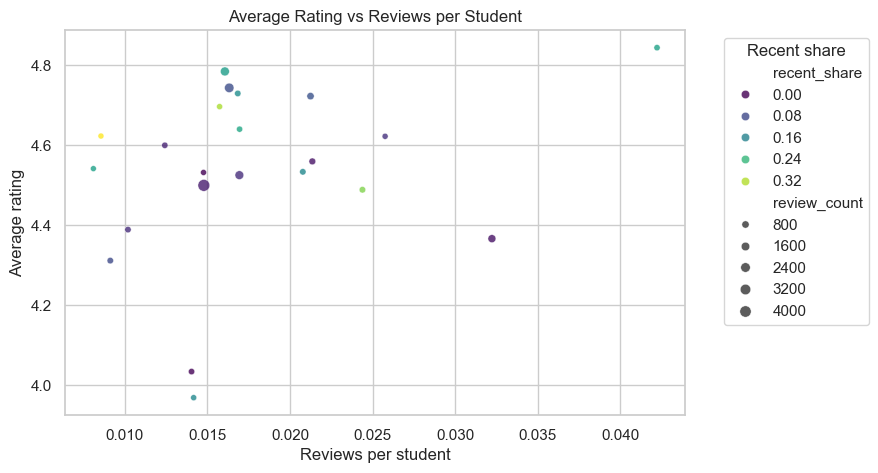

In [162]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=course_summary, x='reviews_per_student', y='avg_rating', size='review_count', hue='recent_share', palette='viridis', alpha=0.8)
plt.title('Average Rating vs Reviews per Student')
plt.xlabel('Reviews per student')
plt.ylabel('Average rating')
plt.legend(title='Recent share', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


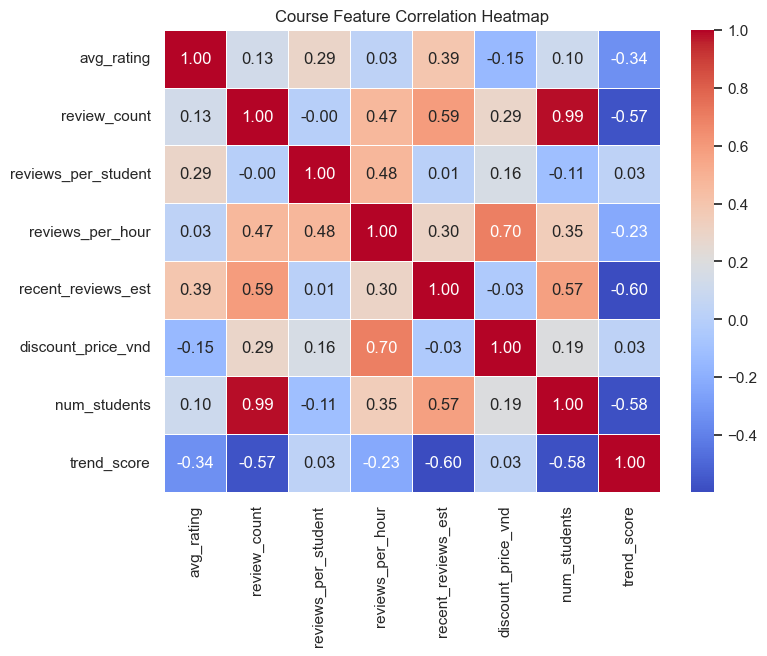

In [163]:
corr_fields = course_summary[['avg_rating','review_count','reviews_per_student','reviews_per_hour','recent_reviews_est','discount_price_vnd','num_students','trend_score']].copy()
corr_matrix = corr_fields.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Course Feature Correlation Heatmap')
plt.show()


## 7. Sentiment keywords

In [164]:
positive_tokens = combined.loc[combined['sentiment_label'] == 'positive', 'tokens']
negative_tokens = combined.loc[combined['sentiment_label'] == 'negative', 'tokens']
neutral_tokens = combined.loc[combined['sentiment_label'] == 'neutral', 'tokens']

keyword_records = []
for scope_name, token_series in [
    ('positive', positive_tokens),
    ('negative', negative_tokens),
    ('neutral', neutral_tokens)
]:
    keyword_records.append({
        'sentiment_scope': scope_name,
        'ngram': 'unigram',
        'keywords': top_ngrams(token_series, 1, 15)
    })
    keyword_records.append({
        'sentiment_scope': scope_name,
        'ngram': 'bigram',
        'keywords': top_ngrams(token_series, 2, 10)
    })

keyword_df = pd.DataFrame(keyword_records)
keyword_df


,sentiment_scope,ngram,keywords
0,positive,unigram,"[(good, 3540), (great, 2286), (well, 1154), (e..."
1,positive,bigram,"[(easy understand, 334), (easy follow, 243), (..."
2,negative,unigram,"[(time, 56), (like, 56), (hard, 40), (lot, 39)..."
3,negative,bigram,"[(waste time, 16), (waste money, 10), (lot tim..."
4,neutral,unigram,"[(nice, 379), (like, 300), (learning, 238), (y..."
5,neutral,bigram,"[(data science, 46), (machine learning, 41), (..."


In [165]:
keyword_df.assign(
    keywords_formatted=keyword_df['keywords'].apply(lambda pairs: '; '.join(f"{term} ({count})" for term, count in pairs))
)[['sentiment_scope', 'ngram', 'keywords_formatted']]


,sentiment_scope,ngram,keywords_formatted
0,positive,unigram,good (3540); great (2286); well (1154); excell...
1,positive,bigram,easy understand (334); easy follow (243); well...
2,negative,unigram,time (56); like (56); hard (40); lot (39); sho...
3,negative,bigram,waste time (16); waste money (10); lot time (1...
4,neutral,unigram,nice (379); like (300); learning (238); yes (2...
5,neutral,bigram,data science (46); machine learning (41); look...


### Additional tables

In [166]:
engagement_table = (course_summary[['course_title','avg_rating','review_count','reviews_per_student','reviews_per_hour','recent_reviews_density']]
    .sort_values('reviews_per_student', ascending=False)
    .head(10)
    .reset_index(drop=True))
engagement_table


,course_title,avg_rating,review_count,reviews_per_student,reviews_per_hour,recent_reviews_density
0,Generative AI 2025 Executive Briefing: LLMs fo...,4.844186,215,0.042215,71.666667,15.000000
1,The Product Management for AI & Data Science C...,4.366507,1251,0.032221,312.750000,5.500000
2,Introduction to Data Engineering using Generat...,4.622449,98,0.025756,16.333333,0.833333
3,AI Agents: Building Teams of LLM Agents that W...,4.488796,357,0.024384,39.666667,11.666667
4,AI-Agents: Automation & Business with LangChai...,4.559730,519,0.021350,51.900000,1.000000
5,AI Automation: Build LLM Apps & AI-Agents with...,4.722973,814,0.021240,58.142857,5.285714
6,"n8n - AI Agents, AI Automations & AI Voice Age...",4.533654,312,0.020775,5.672727,0.963636
7,AI Agents & Workflows - The Practical Guide,4.640351,171,0.016946,42.750000,9.250000
8,"Complete Data Science,Machine Learning,DL,NLP ...",4.525386,1812,0.016933,18.303030,0.868687
9,Data Science & AI Masters 2025 - From Python T...,4.729730,296,0.016836,3.020408,0.530612


In [167]:
momentum_table = (course_summary[['course_title','trend_score','trend_per_review','recent_share','recent_reviews_est']]
    .sort_values('trend_score', ascending=False)
    .head(10)
    .reset_index(drop=True))
momentum_table


,course_title,trend_score,trend_per_review,recent_share,recent_reviews_est
0,AI Agents: Building Teams of LLM Agents that W...,0.222685,0.000624,0.294118,105.000000
1,Generative AI for Data Engineering and Data Pr...,0.169016,0.002167,0.000000,0.000000
2,Introduction to Data Engineering using Generat...,-0.031864,-0.000325,0.051020,5.000000
3,AWS Certified Machine Learning Specialty Full ...,-0.146266,-0.000585,0.004000,1.000000
4,"The Complete AI Coding Course (2025) - Cursor,...",-0.272077,-0.002429,0.169643,19.000000
5,AWS Certified Machine Learning Engineer Associ...,-0.391987,-0.001221,0.080997,26.000000
6,[NEW] Google Cloud Generative AI Leader - 6 Fu...,-0.440630,-0.003612,0.316239,38.581197
7,AI-Agents: Automation & Business with LangChai...,-0.462816,-0.000892,0.019268,10.000000
8,LangGraph- Develop LLM powered AI agents with ...,-0.465224,-0.001899,0.036735,9.000000
9,Complete MLOps Bootcamp With 10+ End To End ML...,-0.580909,-0.002045,0.045775,13.000000


In [168]:
value_table = (course_summary[['course_title','discount_price_vnd','discount_pct','rating_to_price_ratio','discount_price_per_student']]
    .sort_values('rating_to_price_ratio', ascending=False)
    .head(10)
    .reset_index(drop=True))
value_table


,course_title,discount_price_vnd,discount_pct,rating_to_price_ratio,discount_price_per_student
0,[NEW] Google Cloud Generative AI Leader - 6 Fu...,279000.0,0.641849,0.000017,35.986070
1,Generative AI 2025 Executive Briefing: LLMs fo...,289000.0,0.574374,0.000017,56.744551
2,Introduction to Data Engineering using Generat...,279000.0,0.650814,0.000017,73.324573
3,AI-Agents: Automation & Business with LangChai...,289000.0,0.275689,0.000016,11.888601
4,Complete MLOps Bootcamp With 10+ End To End ML...,279000.0,0.763359,0.000016,10.011483
5,AI Agents & Workflows - The Practical Guide,299000.0,0.727934,0.000016,29.630364
6,The Complete Agentic AI Engineering Course (2025),309000.0,0.728709,0.000015,2.552264
7,Data Science & AI Masters 2025 - From Python T...,309000.0,0.750605,0.000015,17.575792
8,AI Agents: Building Teams of LLM Agents that W...,299000.0,0.748528,0.000015,20.422102
9,Learn Agentic AI – Build Multi-Agent Automatio...,309000.0,0.723861,0.000015,38.313701


## 8. Persist curated tables and figures

In [169]:
output_dir = BASE_DIR / 'outputs'
figures_dir = output_dir / 'figures'
tables_dir = output_dir / 'tables'
for path_obj in [output_dir, figures_dir, tables_dir]:
    path_obj.mkdir(parents=True, exist_ok=True)

missing_summary = combined.isna().sum().to_frame(name='missing_count')
missing_summary['missing_pct'] = missing_summary['missing_count'] / len(combined)
missing_summary.to_csv(tables_dir / 'missing_values.csv')

reviews_per_course.to_csv(tables_dir / 'reviews_per_course.csv', index=False)
course_summary.to_csv(tables_dir / 'course_summary.csv', index=False)
top_courses.to_csv(tables_dir / 'top_courses.csv', index=False)
bottom_courses.to_csv(tables_dir / 'bottom_courses.csv', index=False)
keyword_df.to_csv(tables_dir / 'keyword_summary_raw.csv', index=False)
weekly_trend.to_csv(tables_dir / 'weekly_trend.csv', index=False)
engagement_table.to_csv(tables_dir / 'top_engagement_courses.csv', index=False)
momentum_table.to_csv(tables_dir / 'momentum_leaders.csv', index=False)
value_table.to_csv(tables_dir / 'value_courses.csv', index=False)

plt.figure(figsize=(8, 5))
sns.histplot(combined, x='rating_value_filled', bins=20, color='#2563eb')
plt.title('Rating distribution')
plt.xlabel('Rating value')
plt.ylabel('Review count')
plt.tight_layout()
plt.savefig(figures_dir / 'rating_distribution.png', dpi=200)
plt.close()

plt.figure(figsize=(8, 5))
sns.lineplot(data=weekly_trend, x='weeks_ago', y='review_count', marker='o', label='Weekly count')
sns.lineplot(data=weekly_trend, x='weeks_ago', y='review_count_roll4', marker='o', label='4-week rolling mean')
plt.gca().invert_xaxis()
plt.title('Weekly review volume (smaller weeks = more recent)')
plt.xlabel('Weeks ago')
plt.ylabel('Review count')
plt.legend()
plt.tight_layout()
plt.savefig(figures_dir / 'weekly_review_trend.png', dpi=200)
plt.close()

plt.figure(figsize=(8, 5))
sns.histplot(course_summary['reviews_per_student'].dropna(), bins=30, color='#f97316')
plt.title('Reviews per Student Distribution')
plt.xlabel('Reviews per student')
plt.ylabel('Number of courses')
plt.tight_layout()
plt.savefig(figures_dir / 'reviews_per_student_distribution.png', dpi=200)
plt.close()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=course_summary, x='reviews_per_student', y='avg_rating', size='review_count', hue='recent_share', palette='viridis', alpha=0.8)
plt.title('Average Rating vs Reviews per Student')
plt.xlabel('Reviews per student')
plt.ylabel('Average rating')
plt.legend(title='Recent share', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(figures_dir / 'reviews_per_student_vs_rating.png', dpi=200)
plt.close()

corr_fields = course_summary[['avg_rating','review_count','reviews_per_student','reviews_per_hour','recent_reviews_est','discount_price_vnd','num_students','trend_score']].copy()
corr_matrix = corr_fields.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Course Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig(figures_dir / 'course_feature_correlation.png', dpi=200)
plt.close()


In [170]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined, x='course_badge', y='rating_value_filled', hue='skill_level')
plt.xticks(rotation=30, ha='right')
plt.title('Ratings by badge and skill level')
plt.xlabel('Course badge')
plt.ylabel('Rating value')
plt.legend(title='Skill level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(figures_dir / 'ratings_by_badge_skill.png', dpi=200)
plt.close()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=course_summary, x='discount_price_vnd', y='avg_rating', size='review_count', hue='recent_share', palette='viridis')
plt.title('Discount price vs average rating')
plt.xlabel('Discount price (VND)')
plt.ylabel('Average rating')
plt.tight_layout()
plt.savefig(figures_dir / 'price_vs_rating.png', dpi=200)
plt.close()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=course_summary, x='discount_price_vnd', y='num_students', size='review_count', hue='avg_rating', palette='coolwarm')
plt.title('Discount price vs student count')
plt.xlabel('Discount price (VND)')
plt.ylabel('Number of students')
plt.tight_layout()
plt.savefig(figures_dir / 'price_vs_students.png', dpi=200)
plt.close()

skill_summary = (combined.groupby('skill_level')
    .agg(avg_rating=('rating_value_filled', 'mean'), review_count=('course_slug', 'size'))
    .reset_index()
)
plt.figure(figsize=(8, 5))
sns.barplot(data=skill_summary, x='skill_level', y='avg_rating', color='#10b981')
plt.title('Average rating by skill level')
plt.xlabel('Skill level')
plt.ylabel('Average rating')
plt.tight_layout()
plt.savefig(figures_dir / 'rating_by_skill_level.png', dpi=200)
plt.close()


## 9. Quick takeaway snapshot

In [171]:
basic_profile = {
    'total_reviews': len(combined),
    'unique_courses': combined['course_slug'].nunique(),
    'unique_reviewers': combined['reviewer_name'].nunique(),
    'missing_ratings': int(combined['rating_missing'].sum()),
    'duplicate_reviews': int(duplicate_mask.sum()),
    'median_weeks_ago': float(combined['weeks_ago'].median(skipna=True)) if combined['weeks_ago'].notna().any() else np.nan
}

basic_profile


{'total_reviews': 16165,
 'unique_courses': 22,
 'unique_reviewers': 12971,
 'missing_ratings': 0,
 'duplicate_reviews': 194,
 'median_weeks_ago': 26.07}

In [172]:
price_correlations = {
    'corr_discount_price_vs_avg_rating': course_summary['discount_price_vnd'].corr(course_summary['avg_rating']),
    'corr_discount_price_vs_num_students': course_summary['discount_price_vnd'].corr(course_summary['num_students']),
    'corr_price_per_hour_vs_avg_rating': course_summary['price_per_hour'].corr(course_summary['avg_rating']),
    'corr_discount_pct_vs_recent_share': course_summary['discount_pct'].corr(course_summary['recent_share'])
}
price_correlations


{'corr_discount_price_vs_avg_rating': np.float64(-0.1459911068089651),
 'corr_discount_price_vs_num_students': np.float64(0.19438244235378097),
 'corr_price_per_hour_vs_avg_rating': np.float64(0.06119745328622163),
 'corr_discount_pct_vs_recent_share': np.float64(0.19701594375275835)}